# Anomaly detection

**Purpose**: In this notebook, I am going to describe three different (basic) anomaly detection method, all based on unsupervised learning. Then I will discuss advantagous and disadvantagous of each of these methods. The methods I used here are very simple and basic, all based on sklearn package.

## Outline:

#### A) K-mean klustering
#### B) Reconstruction based
#### C) Isolation forest

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances
import matplotlib.pyplot as plt
from typing import Union

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_path='../data/'

## A) K-mean clustering

In [4]:
def do_clustering(df:pd.DataFrame,n_clusters:int):
    data=df.copy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans

def apply_pca(data:pd.DataFrame,centroids:np.ndarray,n_components:int=2):
    
    pca=PCA(n_components=n_components)    
    data_reduced = pca.fit_transform(data)
    centroids_reduced = pca.transform(centroids)
    return data_reduced,centroids_reduced


def plot_clusters(data:pd.DataFrame,feature_num:list,model):
    features=data.columns.tolist()
    model_result_df=pd.DataFrame(data=model.cluster_centers_,columns=features)
    feature_1=features[feature_num[0]]
    feature_2=features[feature_num[1]]
    plt.scatter(data.loc[:,feature_1], data.loc[:,feature_2], c=model.labels_, cmap='viridis')
    plt.scatter(model_result_df.loc[:,feature_1], model_result_df.loc[:,feature_2], marker='*', c='red', s=200)
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title('K-Means Clustering')
    plt.show()
    

def find_anomaly(data:pd.DataFrame,kmeans,threshold:float=1):
    """ takes the data and kmeans. Find the points that their distance from the center of their cluster is bigger than the mean+threshold*std of the data of that cluster

    Args:
        data (pd.DataFrame): _description_
        kmeans (_type_): _description_
        threshold (float, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    df_distances=pd.DataFrame(index=data.index,data=pairwise_distances(data, kmeans.cluster_centers_))
    df_mean=pd.DataFrame(columns=df_distances.columns,index=['min','max','mean','std'])
    df_distances['label']=kmeans.labels_
    for col in df_mean.columns: 
        df_mean.loc['mean',col]=df_distances[df_distances['label']==col][col].mean()
        df_mean.loc['min',col]=df_distances[df_distances['label']==col][col].min()
        df_mean.loc['max',col]=df_distances[df_distances['label']==col][col].max()
        df_mean.loc['std',col]=df_distances[df_distances['label']==col][col].describe()['std']
    df_anomaly=pd.DataFrame(index=df_distances.index,columns=['distance','mean','std'])
    for i in df_distances.index:
        df_anomaly.loc[i,'distance'] = df_distances.loc[i,kmeans.labels_[i]]
        df_anomaly.loc[i,'mean']=df_mean.loc['mean',kmeans.labels_[i]]
        df_anomaly.loc[i,'std']=df_mean.loc['std',kmeans.labels_[i]]
    return df_anomaly[df_anomaly['distance']>abs(df_anomaly['mean']+threshold*df_anomaly['std'])].index.tolist()



def anomaly_plot_pca(data:pd.DataFrame,centroids:np.ndarray,anomalies:list):
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)
    centroids_reduced = pca.transform(centroids)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], marker='*', c='green', s=200)
    plt.scatter(data_reduced[anomalies, 0], data_reduced[anomalies, 1], marker='+', c='red', s=100)
    plt.xlabel('reduced dimension 1')
    plt.ylabel('reduced dimension 2')
    plt.title('K-Means Clustering and anomaly points')
    plt.show()
    





/Users/fariborzparhizgar/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/fariborzparhizgar/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


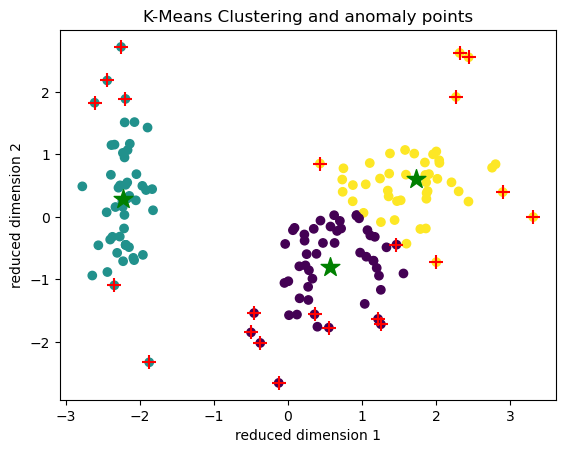

In [3]:
df=pd.read_csv('../data/IRIS.csv')
features=df.drop(columns=['species']).columns.tolist()
scaler=StandardScaler()
df_scaled=pd.DataFrame(columns=features,index=df.index)
df_scaled[features]=scaler.fit_transform(df[features])
kmeans=do_clustering(df=df_scaled,n_clusters=3)
anomalies=find_anomaly(data=df_scaled,kmeans=kmeans,threshold=0.95)
anomaly_plot_pca(data=df_scaled,centroids=kmeans.cluster_centers_,anomalies=anomalies)

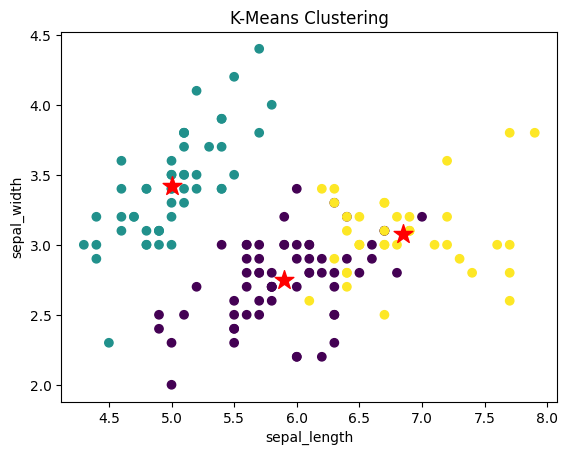

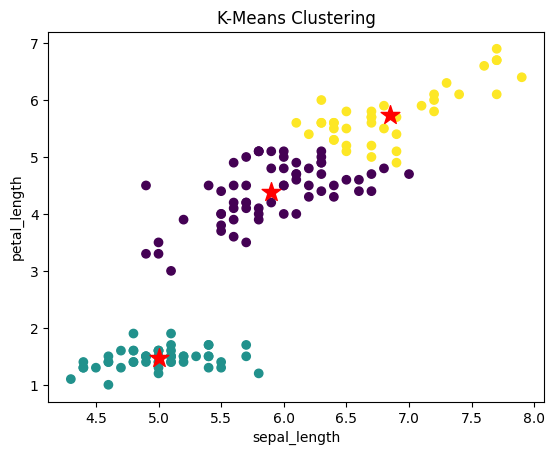

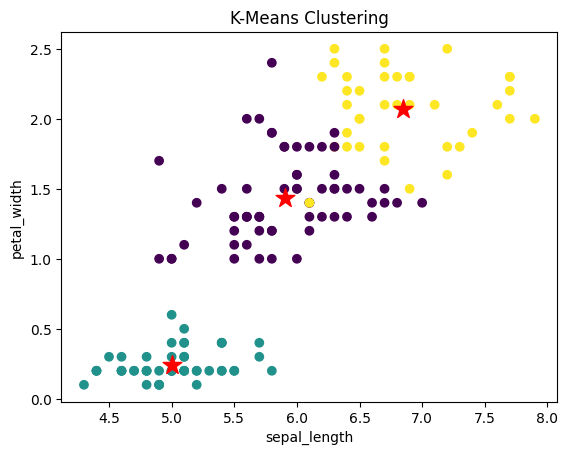

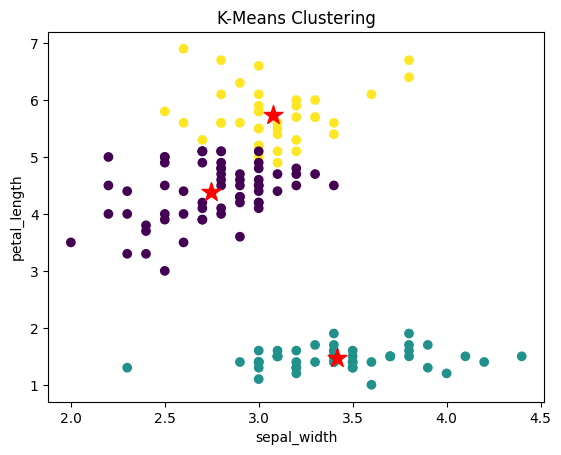

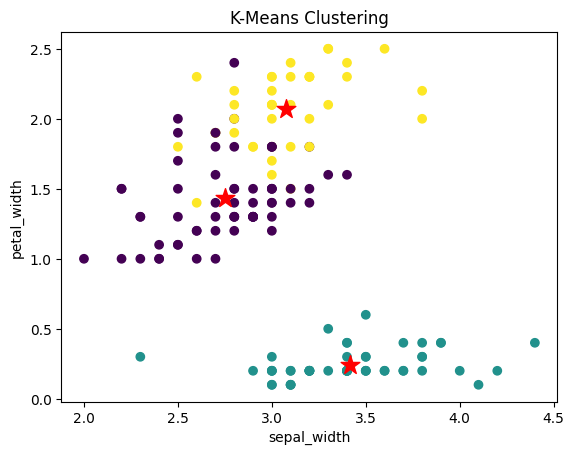

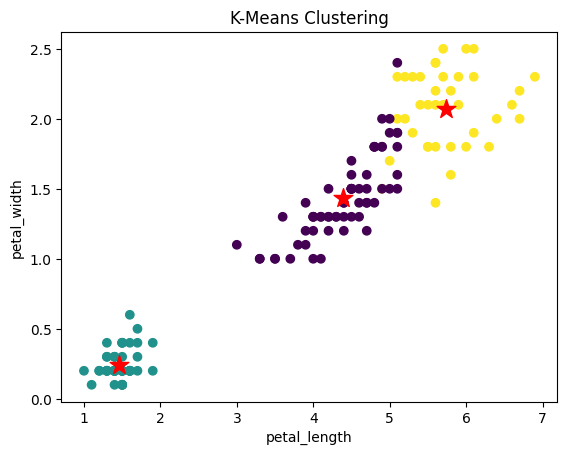

In [37]:
df_iris=pd.read_csv(data_path+'IRIS.csv')
features=df_iris.drop(columns=['species']).columns.tolist()
kmeans = do_clustering(df=df_iris,features=features,n_clusters=3)
kmeans.cluster_centers_
for i in range(len(features)-1):
    for j in range(i+1,len(features)):
        plot_clusters(data=df_iris[features],feature_num=[i,j],model=kmeans)
#plot_clusters(data=df_iris[features],feature_num=[3,2],model=kmeans)




/Users/fariborz/miniconda3/envs/mmm/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


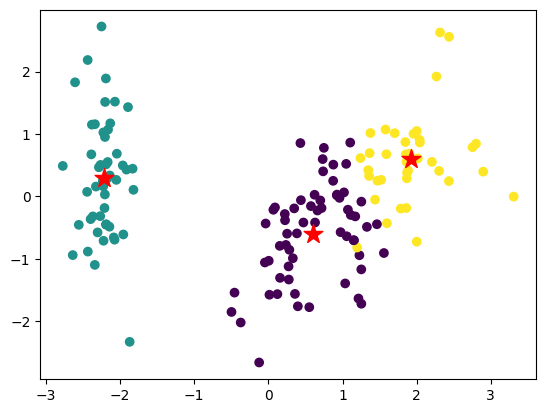

In [56]:
data=df_iris[features]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_scaled)
centroids_scaled = scaler.transform(kmeans.cluster_centers_)
centroids_reduced = pca.transform(centroids_scaled)

# Plot data points and cluster centroids
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], marker='*', c='red', s=200)


### A-1) Anomaly detection:

/Users/fariborz/miniconda3/envs/mmm/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


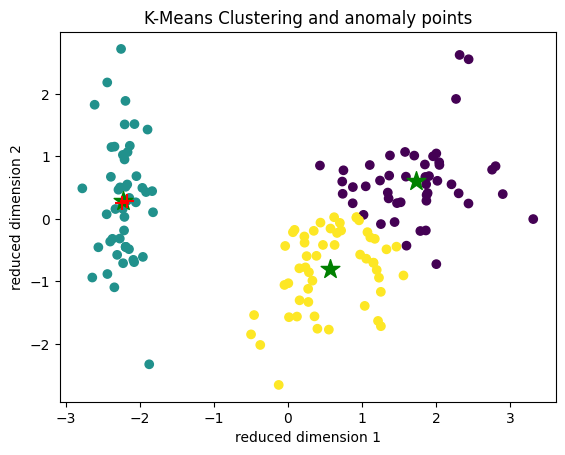

,distance,mean,std
41,2.661396,0.822538,0.546848
60,1.978225,0.85892,0.323871


In [102]:
centers=[[0,0],[1,0],[-1,0]]
data=[[1,2],[2,3],[4,5],[6,2],[1,1],[-1,-1]]
pd.DataFrame(pairwise_distances(data,centers)).min(axis=1)

0    2.000000
1    3.162278
2    5.830952
3    5.385165
4    1.000000
5    1.000000
dtype: float64

In [88]:
kmeans.cluster_centers_

array([[ 1.13597027,  0.09659843,  0.996271  ,  1.01717187],
       [-1.01457897,  0.84230679, -1.30487835, -1.25512862],
       [-0.05021989, -0.88029181,  0.34753171,  0.28206327]])

/Users/fariborz/miniconda3/envs/mmm/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


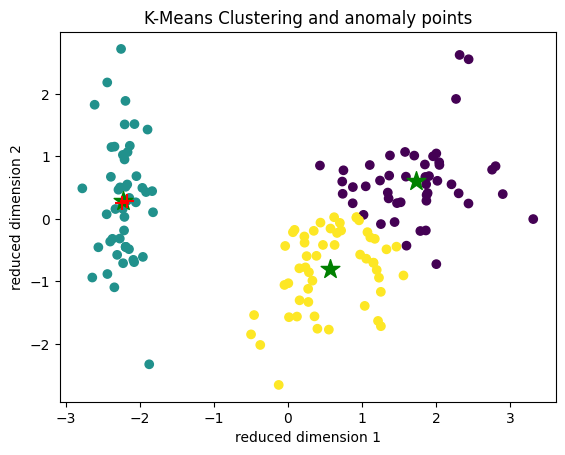

In [85]:
df=pd.read_csv('../data/IRIS.csv')
features=df.drop(columns=['species']).columns.tolist()
scaler=StandardScaler()
df_scaled=pd.DataFrame(columns=features,index=df.index)
df_scaled[features]=scaler.fit_transform(df[features])
kmeans=do_clustering(df=df_scaled,n_clusters=3)
anomalies=find_anomaly(data=df_scaled,kmeans=kmeans,threshold=0.95)
anomaly_plot_pca(data=df_scaled,centroids=kmeans.cluster_centers_,anomalies=anomalies)


In [76]:
data_reduced[[7,4],0]

array([-2.62648199, -2.72859298])

In [68]:
data=df_iris[features]
anomalies=find_anomaly(data=df_scaled,kmeans=kmeans,threshold=0.95)


numpy.ndarray

In [43]:
data=df_iris[features]
h=0.02
x_min, x_max = data.iloc[:, 0].min() - 1, data.iloc[:, 0].max() + 1
y_min, y_max = data.iloc[:, 1].min() - 1, data.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
yy


array([[1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       [1.02, 1.02, 1.02, ..., 1.02, 1.02, 1.02],
       [1.04, 1.04, 1.04, ..., 1.04, 1.04, 1.04],
       ...,
       [5.34, 5.34, 5.34, ..., 5.34, 5.34, 5.34],
       [5.36, 5.36, 5.36, ..., 5.36, 5.36, 5.36],
       [5.38, 5.38, 5.38, ..., 5.38, 5.38, 5.38]])

In [53]:
xx

array([[3.3 , 3.32, 3.34, ..., 8.84, 8.86, 8.88],
       [3.3 , 3.32, 3.34, ..., 8.84, 8.86, 8.88],
       [3.3 , 3.32, 3.34, ..., 8.84, 8.86, 8.88],
       ...,
       [3.3 , 3.32, 3.34, ..., 8.84, 8.86, 8.88],
       [3.3 , 3.32, 3.34, ..., 8.84, 8.86, 8.88],
       [3.3 , 3.32, 3.34, ..., 8.84, 8.86, 8.88]])

In [52]:
np.arange(x_min, x_max, h)

array([3.3 , 3.32, 3.34, 3.36, 3.38, 3.4 , 3.42, 3.44, 3.46, 3.48, 3.5 ,
       3.52, 3.54, 3.56, 3.58, 3.6 , 3.62, 3.64, 3.66, 3.68, 3.7 , 3.72,
       3.74, 3.76, 3.78, 3.8 , 3.82, 3.84, 3.86, 3.88, 3.9 , 3.92, 3.94,
       3.96, 3.98, 4.  , 4.02, 4.04, 4.06, 4.08, 4.1 , 4.12, 4.14, 4.16,
       4.18, 4.2 , 4.22, 4.24, 4.26, 4.28, 4.3 , 4.32, 4.34, 4.36, 4.38,
       4.4 , 4.42, 4.44, 4.46, 4.48, 4.5 , 4.52, 4.54, 4.56, 4.58, 4.6 ,
       4.62, 4.64, 4.66, 4.68, 4.7 , 4.72, 4.74, 4.76, 4.78, 4.8 , 4.82,
       4.84, 4.86, 4.88, 4.9 , 4.92, 4.94, 4.96, 4.98, 5.  , 5.02, 5.04,
       5.06, 5.08, 5.1 , 5.12, 5.14, 5.16, 5.18, 5.2 , 5.22, 5.24, 5.26,
       5.28, 5.3 , 5.32, 5.34, 5.36, 5.38, 5.4 , 5.42, 5.44, 5.46, 5.48,
       5.5 , 5.52, 5.54, 5.56, 5.58, 5.6 , 5.62, 5.64, 5.66, 5.68, 5.7 ,
       5.72, 5.74, 5.76, 5.78, 5.8 , 5.82, 5.84, 5.86, 5.88, 5.9 , 5.92,
       5.94, 5.96, 5.98, 6.  , 6.02, 6.04, 6.06, 6.08, 6.1 , 6.12, 6.14,
       6.16, 6.18, 6.2 , 6.22, 6.24, 6.26, 6.28, 6.

## B) reconstruction-based anomaly detection

In [54]:
a='99%'
int(a.replace('%',''))

99

In [60]:
def find_anomaly_reconstruction(data:pd.DataFrame,n_components:int,threshold:Union[float,str]):
    pca=PCA(n_components=n_components)
    df_reduced = pd.DataFrame(data=pca.fit_transform(data),index=data.index)
    df_reconstructed = pd.DataFrame(data=pca.inverse_transform(df_reduced),columns=data.columns,index=data.index)
    reconstruction_errors = np.mean(np.square(data - df_reconstructed), axis=1)
    ###
    if isinstance(threshold,float) or isinstance(threshold,int):
        mean_error = np.mean(reconstruction_errors)
        std_error = np.std(reconstruction_errors)
        threshold = mean_error + threshold * std_error
    elif isinstance(threshold,str) and threshold.endswith('%'):
        percentile=int(threshold.replace('%',''))
        threshold = np.percentile(reconstruction_errors, percentile)
    
    ###
    anomalies = np.where(reconstruction_errors > threshold)[0]
    return list(anomalies)

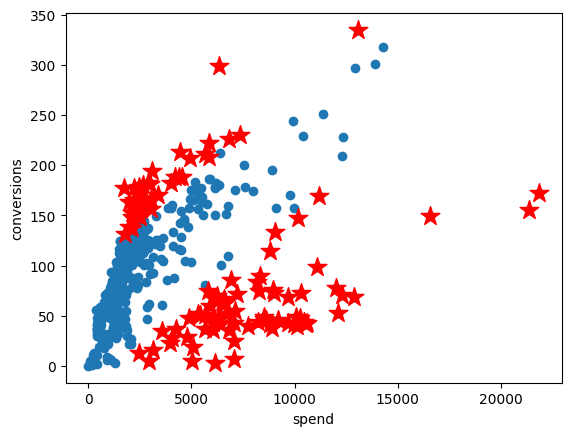

In [61]:
df_curve=pd.read_csv('../data/curve_dr.csv')
features=['spend','conversions']
df_original=df_curve[features]
#df_iris=pd.read_csv('../data/IRIS.csv')
#features=df_iris.columns[:-1].tolist()
#df_original=df_iris[features]
## scaling
scaler=StandardScaler()
df_scaled=pd.DataFrame(columns=df_original.columns,index=df_original.index,data=scaler.fit_transform(df_original))


anomalies=find_anomaly_reconstruction(data=df_scaled,n_components=1,threshold=0)
plt.scatter(df_original.iloc[:, 0], df_original.iloc[:, 1])
plt.scatter(df_original.iloc[anomalies, 0], df_original.iloc[anomalies, 1], marker='*', c='red', s=200)
#plt.scatter(data_reduced[anomalies, 0], data_reduced[anomalies, 1], marker='+', c='red', s=100)
plt.xlabel(features[0])
plt.ylabel(features[1])
#plt.title('K-Means Clustering and anomaly points')
plt.show()


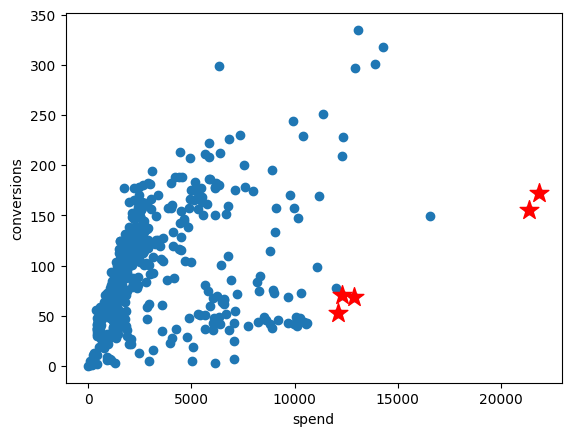

In [ ]:
def anomaly_plot_pca(data:pd.DataFrame,centroids:np.ndarray,anomalies:list):
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data)
    centroids_reduced = pca.transform(centroids)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=kmeans.labels_, cmap='viridis')
    plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], marker='*', c='green', s=200)
    plt.scatter(data_reduced[anomalies, 0], data_reduced[anomalies, 1], marker='+', c='red', s=100)
    plt.xlabel('reduced dimension 1')
    plt.ylabel('reduced dimension 2')
    plt.title('K-Means Clustering and anomaly points')
    plt.show()

## C) Isolation Forest

/Users/fariborz/miniconda3/envs/mmm/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


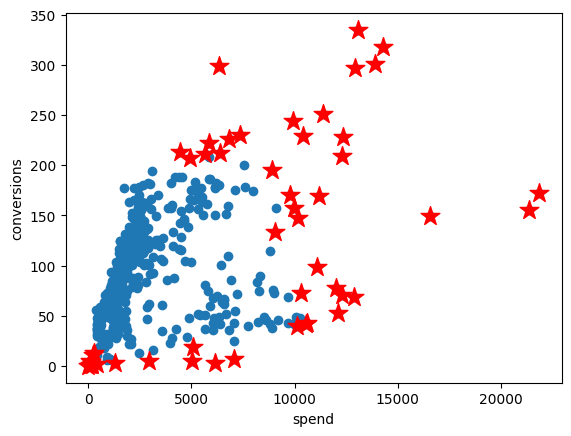

In [52]:
from sklearn.ensemble import IsolationForest
threshold = -0.0 
contamination=0.1
isolation_forest = IsolationForest(contamination=contamination) # it is somehow the percentage of expected anomalies in the dataset (5% anomaly)

##

df_curve=pd.read_csv('../data/curve_dr.csv')
features=['spend','conversions']
df_original=df_curve[features]
##

isolation_forest.fit(df_original)
anomaly_scores = isolation_forest.decision_function(df_original)

anomalies = np.where(anomaly_scores < threshold)[0]
anomalies

plt.scatter(df_original.iloc[:, 0], df_original.iloc[:, 1])
plt.scatter(df_original.iloc[anomalies, 0], df_original.iloc[anomalies, 1], marker='*', c='red', s=200)
#plt.scatter(data_reduced[anomalies, 0], data_reduced[anomalies, 1], marker='+', c='red', s=100)
plt.xlabel(features[0])
plt.ylabel(features[1])
#plt.title('K-Means Clustering and anomaly points')
plt.show()



(498, 2)